#### Checking Python version

In [32]:
!python -V

Python 3.8.8


#### Importing libraries

In [33]:
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from datetime import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib inline

from feature_engine import encoding as ce
from feature_engine import imputation as mdi
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics

#### Importing data

In [34]:
INPUT_FILEPATH = '../inputs'
INPUT_FILENAME = 'master_data - modified3.csv'

INDEX = 'policy_number'
DATE_COLS = ['proposal_received_date', 'policy_issue_date', 'agent_dob', 'agent_doj']
NA_VALUES = ['', 'NA', 'N/A', 'NULL', 'null', '?', '*', '#N/A', '#VALUE!']
DTYPE_DICT = {'zipcode': 'str', 'agent_code': 'str'} ## THese columns should be string

In [35]:
input_df = pd.read_csv(os.path.join(INPUT_FILEPATH, INPUT_FILENAME),
                      index_col = INDEX,
                      na_values = NA_VALUES,
                      parse_dates = DATE_COLS,
                      dayfirst = True,
                      dtype = DTYPE_DICT)

In [36]:
input_df.head(20)

,proposal_received_date,policy_issue_date,owner_age,owner_gender,marital_status,num_nominee,smoker,medical,education,occupation,experience,income,zipcode,county,state,negative_zipcode,family_member,existing_num_policy,has_critical_health_history,policy_term,payment_freq,annual_premium,sum_insured,agent_code,agent_dob,agent_doj,agent_status,agent_education,agent_age,agent_tenure_days,agent_persistency,last_6_month_submissions,average_premium,is_reinstated,prev_persistency,num_complaints,target_completion_perc,has_contacted_in_last_6_months,credit_score,lapse
policy_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2020-09-08,2020-09-08,22,Female,Single,1,No,No,Graduate,Sales,1,50000,19111,Philadelphia County,PA,0,1,0,0,25,Annually,377,580019,60503862,1997-07-03,2020-08-31,Active,Graduate,23,8,0.76,35,377,1,0.67,1,0.98,1,762,0
2,2020-08-24,2020-08-26,33,Female,Single,1,No,No,High School,Housewife,0,0,7764,Monmouth County,NJ,0,1,0,0,20,Quaterly,671,829002,60422713,1980-03-28,2018-05-17,Active,High School,40,830,0.87,54,671,0,0.00,4,0.90,1,794,0
3,2020-08-24,2020-08-24,29,Female,Married,1,No,No,Lt High School,Other Service,13,100000,26335,Braxton County,WV,0,2,1,0,10,Annually,210,659027,60450939,1978-06-25,2019-02-25,Inactive,Some College,42,546,0.93,0,579,0,0.00,8,0.93,1,800,0
4,2020-08-24,2020-08-24,57,Male,Divorced,1,No,Yes,Graduate,Military,36,242286,98241,Skagit County,WA,0,3,0,0,15,Annually,1863,612890,60394377,1993-05-05,2017-07-10,Active,Graduate,27,1141,0.78,29,1333,1,0.72,8,0.95,1,850,0
5,2020-08-24,2020-08-25,32,Female,Divorced,1,No,No,Post Graduate,Teacher,8,20434,78160,Wilson County,TX,0,1,1,0,20,Annually,730,879549,60491531,1967-12-05,2020-03-20,Active,Graduate,53,157,0.89,44,652,0,0.00,8,0.89,0,745,1
6,2020-08-24,2020-08-29,27,Male,Single,1,Yes,Yes,Graduate,Accountant,6,65000,15938,Cambria County,PA,0,1,0,0,20,Annually,941,862056,60408239,1986-06-05,2017-11-30,Active,Graduate,34,998,0.75,26,1890,0,0.00,8,0.83,0,720,1
7,2020-08-24,2020-08-24,39,Male,Married,1,No,No,High School,Govt Service,21,116539,28707,Jackson County,NC,0,3,0,1,10,Annually,331,529537,60476244,1984-11-03,2019-10-22,Active,Lt High School,36,307,0.81,45,926,0,0.00,13,0.92,0,686,0
8,2020-08-24,2020-09-30,39,Female,Widowed,1,Yes,Yes,Graduate,Shop Owner,18,56924,60129,DeKalb County,IL,0,1,0,1,15,Monthly,566,501114,60237645,NaT,2012-08-23,Active,High School,36,2923,0.98,60,1119,0,0.00,8,0.95,0,838,0
9,2020-08-24,2020-08-26,28,Male,Married,1,No,No,Graduate,IT Service,7,64762,33759,Pinellas County,FL,0,3,0,0,25,Annually,477,465743,60221480,1964-10-26,2011-10-13,Active,Lt High School,56,3238,0.70,40,842,0,0.00,27,0.88,1,773,0


#### Checking data info

In [37]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44948 entries, 1 to 44948
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   proposal_received_date          44948 non-null  datetime64[ns]
 1   policy_issue_date               44948 non-null  datetime64[ns]
 2   owner_age                       44948 non-null  int64         
 3   owner_gender                    44948 non-null  object        
 4   marital_status                  44948 non-null  object        
 5   num_nominee                     44948 non-null  int64         
 6   smoker                          44948 non-null  object        
 7   medical                         44948 non-null  object        
 8   education                       44948 non-null  object        
 9   occupation                      44948 non-null  object        
 10  experience                      44948 non-null  int64         
 11  in

In [38]:
input_df.columns

Index(['proposal_received_date', 'policy_issue_date', 'owner_age',
       'owner_gender', 'marital_status', 'num_nominee', 'smoker', 'medical',
       'education', 'occupation', 'experience', 'income', 'zipcode', 'county',
       'state', 'negative_zipcode', 'family_member', 'existing_num_policy',
       'has_critical_health_history', 'policy_term', 'payment_freq',
       'annual_premium', 'sum_insured', 'agent_code', 'agent_dob', 'agent_doj',
       'agent_status', 'agent_education', 'agent_age', 'agent_tenure_days',
       'agent_persistency', 'last_6_month_submissions', 'average_premium',
       'is_reinstated', 'prev_persistency', 'num_complaints',
       'target_completion_perc', 'has_contacted_in_last_6_months',
       'credit_score', 'lapse'],
      dtype='object')

#### Target variable distribution

In [39]:
input_df['lapse'].value_counts()/len(input_df)*100

0    64.683634
1    35.316366
Name: lapse, dtype: float64

#### Creating feature: time_to_issue

In [40]:
input_df['time_to_issue'] = (input_df['policy_issue_date'] - input_df['proposal_received_date']).dt.days
input_df['time_to_issue'].describe()

count    44948.000000
mean         5.640451
std         11.153843
min          0.000000
25%          0.000000
50%          1.000000
75%          7.000000
max        494.000000
Name: time_to_issue, dtype: float64

#### Creating feature: prem_to_income_ratio

In [41]:
input_df['prem_to_income_ratio'] = np.where(input_df['income'] == 0, 0, (input_df['annual_premium']/input_df['income']))
input_df['prem_to_income_ratio'].describe()

count    44948.000000
mean         0.016824
std          0.025457
min          0.000000
25%          0.004170
50%          0.008553
75%          0.017717
max          0.200000
Name: prem_to_income_ratio, dtype: float64

## --------------------------------------------------------------------------------------------------------------------------------

The objective of this exercise is to create a demoable solution (maybe not the best possible one, given the augmented data). Hence, we are not going to deep dive into EDA and hypothesis testing. Instead, we will focus on building the ML product using different technologies. 

## --------------------------------------------------------------------------------------------------------------------------------

#### Columns to remove

In [42]:
COLS_TO_REM = ['proposal_received_date','policy_issue_date', 'zipcode', 'county', 'state', 'agent_code', 'agent_dob', 'agent_doj']

- `proposal_received_date`: Derived `time_to_issue` from this column
- `policy_issue_date`: Derived `time_to_issue` from this column
- `zipcode`: Too many values, high cardinality
- `county`: Too many values, high cardinality
- `state`: Too many values, high cardinality
- `agent_code`: Id column
- `agent_dob`: Derived `agent_age` from this column
- `agent_doj`: Derived `agent_tenure_days` from this column

In [43]:
temp_df = input_df.drop(COLS_TO_REM, axis = 1)
temp_df.shape

(44948, 34)

In [44]:
input_df.shape

(44948, 42)

## Feature Engineering Steps

#### Missing Value Imputation

We have only one column where missing value is present. `agent_persistency`. Impute missing value with median

In [45]:
agent_persistency_missing_perc = round(temp_df['agent_persistency'].isnull().mean()*100,2)

print(f'Total missing percentage of column agent_persistency is: {agent_persistency_missing_perc}% ')

Total missing percentage of column agent_persistency is: 0.26% 


In [46]:
MISSING_COl = ['agent_persistency']

#### One-Hot Encoding

In [47]:
ONE_HOT_COLS = ['owner_gender', 'marital_status', 'smoker', 'medical', 'education', 'occupation', 'payment_freq',  
                'agent_status', 'agent_education']

#### Normalisation

We will normalise the columns using `StandardScaler` because we have values at different scale

#### Creating train test split

In [48]:
temp_df.columns

Index(['owner_age', 'owner_gender', 'marital_status', 'num_nominee', 'smoker',
       'medical', 'education', 'occupation', 'experience', 'income',
       'negative_zipcode', 'family_member', 'existing_num_policy',
       'has_critical_health_history', 'policy_term', 'payment_freq',
       'annual_premium', 'sum_insured', 'agent_status', 'agent_education',
       'agent_age', 'agent_tenure_days', 'agent_persistency',
       'last_6_month_submissions', 'average_premium', 'is_reinstated',
       'prev_persistency', 'num_complaints', 'target_completion_perc',
       'has_contacted_in_last_6_months', 'credit_score', 'lapse',
       'time_to_issue', 'prem_to_income_ratio'],
      dtype='object')

In [49]:
FEATURES = ['owner_age', 'owner_gender', 'marital_status', 'num_nominee', 'smoker',
       'medical', 'education', 'occupation', 'experience', 'income',
       'negative_zipcode', 'family_member', 'existing_num_policy',
       'has_critical_health_history', 'policy_term', 'payment_freq',
       'annual_premium', 'sum_insured', 'agent_status', 'agent_education',
       'agent_age', 'agent_tenure_days', 'agent_persistency',
       'last_6_month_submissions', 'average_premium', 'is_reinstated',
       'prev_persistency', 'num_complaints', 'target_completion_perc',
       'has_contacted_in_last_6_months', 'credit_score',
       'time_to_issue', 'prem_to_income_ratio']

TARGET = 'lapse'

In [50]:
X_train, X_test, y_train, y_test = train_test_split(temp_df[FEATURES],
                                                    temp_df[TARGET],
                                                    test_size=0.3,
                                                    random_state = 786, 
                                                    shuffle = True,
                                                    stratify = temp_df[TARGET])

X_train.shape, X_test.shape

((31463, 33), (13485, 33))

#### Creating data transformation pipeline

In [51]:
model_input_pipe = Pipeline([
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method = 'median', variables = MISSING_COl )), 
    
    ('onehot_encoder', ce.OneHotEncoder(top_categories=None,
                                        variables= ONE_HOT_COLS,
                                        drop_last=True)),
    
    ('normalisation', StandardScaler()),
    
    ('clf', LogisticRegression(random_state = 786))
])

#### Fitting the pipeline

In [52]:
model_input_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['agent_persistency'])),
                ('onehot_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['owner_gender', 'marital_status',
                                          'smoker', 'medical', 'education',
                                          'occupation', 'payment_freq',
                                          'agent_status', 'agent_education'])),
                ('normalisation', StandardScaler()),
                ('clf', LogisticRegression(random_state=786))])

#### Making predictions

In [53]:
X_train_preds = model_input_pipe.predict_proba(X_train)[:,1]
X_test_preds = model_input_pipe.predict_proba(X_test)[:,1]

prediction = model_input_pipe.predict(X_test)

#### Evaluating model performance - confusion matrix

In [54]:
print(f"\naccuracy: {round(accuracy_score(y_test, prediction)*100,2)}%")
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 75.97%

 [[7570 1153]
 [2087 2675]]

               precision    recall  f1-score   support

           0       0.78      0.87      0.82      8723
           1       0.70      0.56      0.62      4762

    accuracy                           0.76     13485
   macro avg       0.74      0.71      0.72     13485
weighted avg       0.75      0.76      0.75     13485



#### Checking ROC Curve for train and test data

In [55]:
print('Train set')
print('Random Forest roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('Random Forest roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
Random Forest roc-auc: 0.8071642573837079
Test set
Random Forest roc-auc: 0.8026860877433375


#### Plotting the ROC Curve

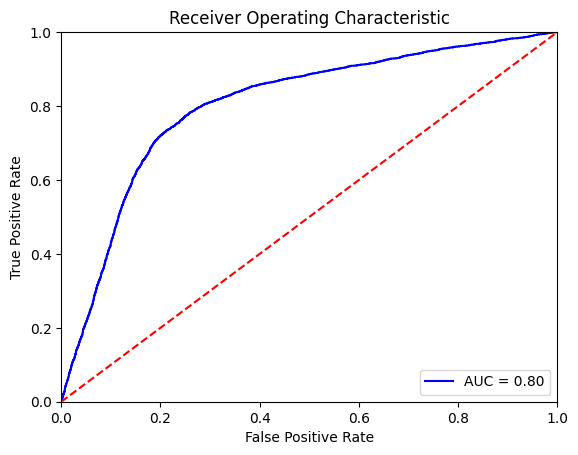

In [56]:
fpr, tpr, threshold = metrics.roc_curve(y_test, X_test_preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Trying with GBM

In [57]:
model_input_pipe = Pipeline([
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method = 'median', variables = MISSING_COl )), 
    
    ('onehot_encoder', ce.OneHotEncoder(top_categories=None,
                                        variables= ONE_HOT_COLS,
                                        drop_last=True)),
    
    ('normalisation', StandardScaler()),
    
    ('clf', GradientBoostingClassifier(random_state = 786))
])

#### Fitting the pipeline

In [58]:
model_input_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['agent_persistency'])),
                ('onehot_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['owner_gender', 'marital_status',
                                          'smoker', 'medical', 'education',
                                          'occupation', 'payment_freq',
                                          'agent_status', 'agent_education'])),
                ('normalisation', StandardScaler()),
                ('clf', GradientBoostingClassifier(random_state=786))])

#### Making prediction

In [59]:
X_train_preds = model_input_pipe.predict_proba(X_train)[:,1]
X_test_preds = model_input_pipe.predict_proba(X_test)[:,1]

prediction = model_input_pipe.predict(X_test)

#### Evaluating model performance - confusion matrix

In [60]:
print(f"\naccuracy: {round(accuracy_score(y_test, prediction)*100,2)}%")
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 81.69%

 [[7060 1663]
 [ 806 3956]]

               precision    recall  f1-score   support

           0       0.90      0.81      0.85      8723
           1       0.70      0.83      0.76      4762

    accuracy                           0.82     13485
   macro avg       0.80      0.82      0.81     13485
weighted avg       0.83      0.82      0.82     13485



#### Checking ROC Curve for train and test data

In [61]:
print('Train set')
print('Random Forest roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('Random Forest roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
Random Forest roc-auc: 0.8498237766648169
Test set
Random Forest roc-auc: 0.8190184069756642


#### Plotting the ROC Curve

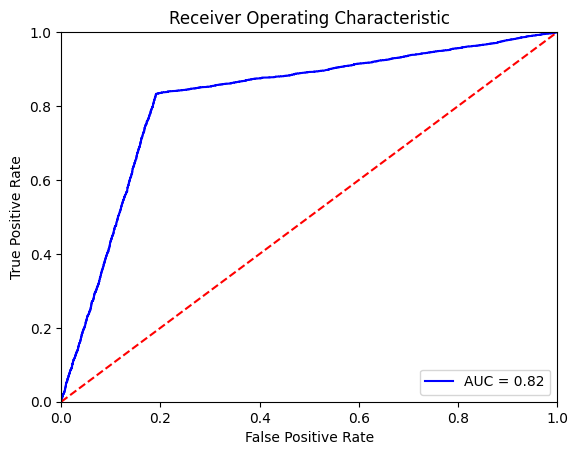

In [62]:
fpr, tpr, threshold = metrics.roc_curve(y_test, X_test_preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This is the best result we can get from this augmented data, which looks more authentic. Finalising this target distribution.